## Importing Required Libraries

In [2]:
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder  # converts categorical labels into numerical values.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (TfidfVectorizer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
spam_data = pd.read_csv('spam.csv', encoding='latin-1', usecols=[0, 1], names=['label', 'message'], skiprows=1)

In [4]:
print(spam_data.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [5]:
# converting label to 0 for ham and 1 for spam
label_encoder = LabelEncoder()
spam_data['label'] = label_encoder.fit_transform(spam_data['label'])

In [6]:
print(spam_data.head())

   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


## Data Processing

### Data Cleaning

In [7]:
# Removing Punctuations & Special Characters
nltk.download('punkt')


def process_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    cleaned_text = ' '.join(tokens)
    return cleaned_text


spam_data['cleaned_message'] = spam_data['message'].apply(process_text)
spam_data.drop(columns=['message'], inplace=True)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jiyamakhija/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
print(spam_data.head())

   label                                    cleaned_message
0      0  go until jurong point crazy available only in ...
1      0                            ok lar joking wif u oni
2      1  free entry in 2 a wkly comp to win fa cup fina...
3      0        u dun say so early hor u c already then say
4      0  nah i do think he goes to usf he lives around ...


### Vectorization
#### Converting cleaned text into numerical data

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used to evaluate the importance of a word in a document relative to a collection of documents

In [9]:
# Initialize TF-IDF Vectorizer with a maximum of 1000 features
# This limits the number of features to the 1000 most frequent terms
vectorizer = TfidfVectorizer(max_features=1000)  

# Fit the vectorizer on the cleaned messages and transform them into a TF-IDF matrix
# X is the resulting matrix where each row is a document, and each column is a term
X = vectorizer.fit_transform(spam_data['cleaned_message'])

print("Shape of TF-IDF matrix:", X.shape)

Shape of TF-IDF matrix: (5572, 1000)


## Preparing Data
### Splitting the data into training (60%), validation (20%), and test (20%)

In [10]:
# Split the data into training (60%) and temp (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, spam_data['label'], test_size=0.4, random_state=42)

# Split the temp set into validation (20%) and test (20%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (3343, 1000)
Validation set size: (1114, 1000)
Test set size: (1115, 1000)


## Building a Neural Network Model

In [11]:
from keras import Input
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(units = 256, activation = 'relu',),
    Dense(units = 128, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [12]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8975 - loss: 0.2454 - val_accuracy: 0.9632 - val_loss: 0.1378
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9860 - loss: 0.0409 - val_accuracy: 0.9686 - val_loss: 0.1519
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9974 - loss: 0.0093 - val_accuracy: 0.9686 - val_loss: 0.2241
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9704 - val_loss: 0.2913
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9967 - loss: 0.0154 - val_accuracy: 0.9713 - val_loss: 0.2101
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9722 - val_loss: 0.2816
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0043 - val_accuracy: 0.9731 - val_loss: 0.3316
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.

## Evaluating the Model

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


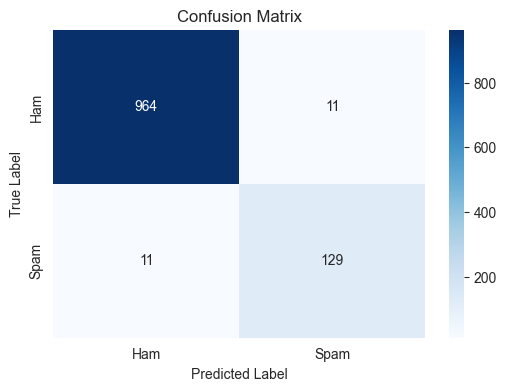

In [13]:
# Use the trained model to predict probabilities for the test data
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to binary class labels
# If the probability is greater than 0.5, classify as positive class (1, spam)
# Otherwise, classify as negative class (0, ham)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate the confusion matrix using true labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.show()

##### True Negatives (964): The model correctly identified 964 messages as ham (not spam).
##### True Positives (129): The model correctly identified 129 messages as spam.
##### False Positives (11) and False Negatives (11): The model incorrectly classified 11 ham messages as spam and 11 spam messages as ham.

----